# MSCA 32018 Natural Language Processing and Cognitive Computing
## Final Project - Entity Identification


Shijia Huang

-----

In [1]:
!pip install -r requirements.txt

  Using cached rake_nltk-1.0.6-py3-none-any.whl (9.1 kB)
  Using cached rake_nltk-1.0.5-py3-none-any.whl (8.7 kB)
  Using cached rake_nltk-1.0.4-py2.py3-none-any.whl


In [2]:
# Import basic libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint
import string
from rake_nltk import Rake

import eli5
import pickle

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
spacy.prefer_gpu()
print(spacy.__version__)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim as gensimvis
#import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

2023-05-16 13:04:55.756764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 13:05:16.177165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-05-16 13:05:16.179056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_

3.5.2


In [5]:
# Import sklearn libraries
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [6]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 16


### Read New Articles with Sentiment Score

In [7]:
%%time

# GCP version
path = "gs://nlp-final-project-data/data/"
df_news = pd.read_parquet(path + 'news_sentiment.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 47s, sys: 9.99 s, total: 1min 57s
Wall time: 1min 57s


(154283, 11)

In [8]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154283 entries, 0 to 154282
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154283 non-null  int64 
 1   date              154283 non-null  object
 2   cleaned title     154283 non-null  object
 3   cleaned text      154283 non-null  object
 4   title_tokens      154283 non-null  object
 5   title_lemmatized  154283 non-null  object
 6   text_tokens       154283 non-null  object
 7   text_lemmatized   154283 non-null  object
 8   title_keywords    154283 non-null  object
 9   text_keywords     154283 non-null  object
 10  sentiment         154283 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 12.9+ MB


In [9]:
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]",5
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, ne

In [10]:
### SAMPLE DATA
df_news = df_news.sample(frac=0.01, random_state=42)
df_news.shape

(1543, 11)

In [11]:
# remove links and special characters
def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'&\S+', '', text)
    text =  re.sub(r'\S+.com', '', text)
    text =  re.sub(r'\S+.ca', '', text)
    text =  re.sub(r'\S+.org', '', text)
    text = re.sub(r'[^a-zA-Z0-9 @ . , : - _]', '', text)
    return text

In [12]:
# clean the text
df_news['cleaned text'] = df_news['cleaned text'].apply(lambda x: remove_links(x))

## Identify Entities from News Text

In [13]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [14]:
from utils import process_text, process_text_sen
nlp = spacy.load('en_core_web_lg')

### With Sentence Segmentation 

In [15]:
# function to extract entities from news text with sentence segmentation
def extract_entities_sen(df):
    with mp.Pool() as pool:
        results = pool.imap_unordered(process_text_sen, df['cleaned text'], chunksize=2000)
        for i, ents in enumerate(results):
            for ent in ents:
                yield df.iloc[i]['id'], ent[0], ent[1]

In [16]:
%%time

ner_spacy_ntext_sen_df = pd.DataFrame(extract_entities_sen(df_news), columns=['id', 'Entities', 'Labels'])
ner_spacy_ntext_sen_df

CPU times: user 14.4 s, sys: 898 ms, total: 15.3 s
Wall time: 8min 36s


,id,Entities,Labels
0,6559,Social GoodDeepali KhannaContributorOpinions,LOC
1,6559,Forbes Contributors,ORG
2,6559,AsiaI,ORG
3,6559,FacebookShare,ORG
4,6559,TwitterShare,ORG
...,...,...,...
120901,185558,ChatGPT,ORG
120902,185558,Italys,GPE
120903,185558,FBI,ORG
120904,185558,headquartersCanada,PERSON


In [33]:
# save dataframe to csv
ner_spacy_ntext_sen_df.to_csv('result/ner_spacy_ntext_sen_df.csv', index=False)

In [17]:
# group by entities and labels
ner_spacy_ntext_sen_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(10)

,Entities,Labels,count
5795,AI,PRODUCT,4449
5793,AI,ORG,2061
11834,ChatGPT,ORG,1314
40721,first,ORDINAL,877
18694,Gray Media Group,ORG,827
25481,Microsoft,ORG,764
18476,Google,ORG,763
42244,one,CARDINAL,722
2123,2020,DATE,570
36634,US,GPE,525


In [18]:
# filter only the entities labelled as organization and count the number of occurences
spacy_org_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'ORG'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_org_sen_top30

,Entities,Labels,count
291,AI,ORG,2061
3778,ChatGPT,ORG,1314
7758,Gray Media Group,ORG,827
11159,Microsoft,ORG,764
7603,Google,ORG,763
12522,OpenAI,ORG,382
19680,pabilities,ORG,343
1711,Artificial Intelligence,ORG,303
10476,ML,ORG,277
8413,IBM,ORG,272


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

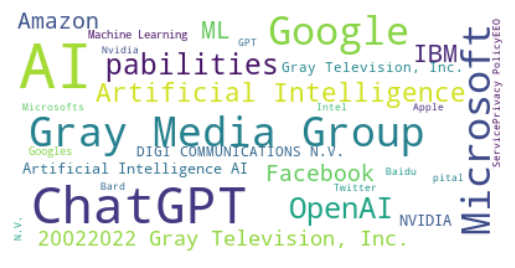

In [19]:
# plot a word cloud
from wordcloud import WordCloud

word_counts = spacy_org_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
# filter only the entities labelled as person and count the number of occurences
spacy_peo_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'PERSON'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_peo_sen_top30

,Entities,Labels,count
4628,Musk,PERSON,78
901,Bing,PERSON,78
2081,Elon Musk,PERSON,74
863,Biden,PERSON,62
6046,Size,PERSON,59
401,Altman,PERSON,47
5753,Sam Altman,PERSON,40
6441,Tian,PERSON,34
6571,Trump,PERSON,34
6099,Sophy,PERSON,33


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

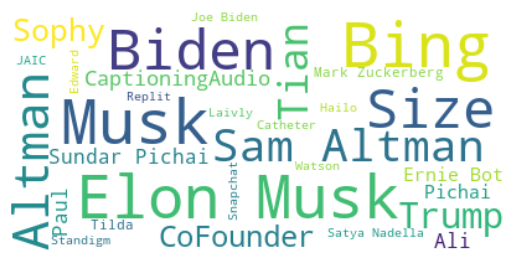

In [21]:
# plot a word cloud

word_counts = spacy_peo_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
# filter only the entities labelled as location and count the number of occurences
spacy_loc_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'GPE'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_loc_sen_top30

,Entities,Labels,count
1876,US,GPE,525
1867,U.S.,GPE,412
1356,PRNewswire,GPE,398
783,India,GPE,371
362,China,GPE,369
1871,UK,GPE,217
838,Japan,GPE,173
324,Canada,GPE,141
615,France,GPE,125
2302,the United States,GPE,125


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

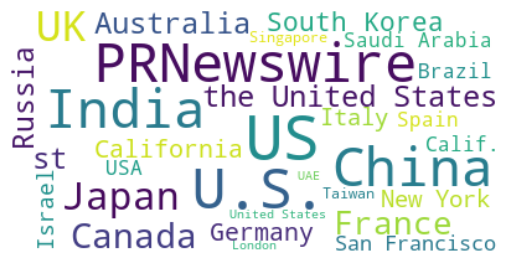

In [23]:
# plot a word cloud

word_counts = spacy_loc_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Without Sentence Segmentation

In [24]:
def extract_entities(df):
    with mp.Pool() as pool:
        results = pool.imap_unordered(process_text, df['cleaned text'], chunksize=2000)
        for i, ents in enumerate(results):
            for ent in ents:
                yield df.iloc[i]['id'], ent[0], ent[1]

In [25]:
%%time

ner_spacy_ntext_df = pd.DataFrame(extract_entities(df_news), columns=['id', 'Entities', 'Labels'])
ner_spacy_ntext_df

CPU times: user 14.6 s, sys: 990 ms, total: 15.5 s
Wall time: 4min 44s


,id,Entities,Labels
0,6559,Social GoodDeepali KhannaContributorOpinions,LOC
1,6559,Forbes Contributors,ORG
2,6559,AsiaI,ORG
3,6559,FacebookShare,ORG
4,6559,TwitterShare,ORG
...,...,...,...
120499,185558,ChatGPT,ORG
120500,185558,Italys,GPE
120501,185558,FBI,ORG
120502,185558,headquartersCanada,PERSON


In [34]:
# save dataframe to csv
ner_spacy_ntext_df.to_csv('result/ner_spacy_ntext_df.csv', index=False)

In [26]:
# group by entities and labels
ner_spacy_ntext_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(10)

,Entities,Labels,count
5770,AI,PRODUCT,4452
5768,AI,ORG,1993
11815,ChatGPT,ORG,1302
40780,first,ORDINAL,876
18683,Gray Media Group,ORG,827
25520,Microsoft,ORG,764
18470,Google,ORG,763
42297,one,CARDINAL,722
2112,2020,DATE,568
36710,US,GPE,526


In [27]:
# filter only the entities labelled as organization and count the number of occurences
spacy_org_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'ORG'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_org_top30

,Entities,Labels,count
294,AI,ORG,1993
3759,ChatGPT,ORG,1302
7736,Gray Media Group,ORG,827
11120,Microsoft,ORG,764
7585,Google,ORG,763
12486,OpenAI,ORG,351
19622,pabilities,ORG,336
1707,Artificial Intelligence,ORG,299
10440,ML,ORG,278
8387,IBM,ORG,270


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

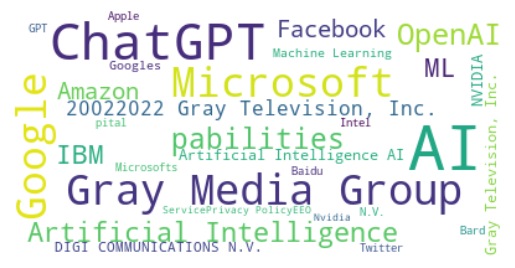

In [28]:
# plot a word cloud

word_counts = spacy_org_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
# filter only the entities labelled as person and count the number of occurences
spacy_peo_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'PERSON'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_peo_top30

,Entities,Labels,count
4665,Musk,PERSON,78
918,Bing,PERSON,78
2094,Elon Musk,PERSON,74
880,Biden,PERSON,62
6090,Size,PERSON,59
410,Altman,PERSON,51
5794,Sam Altman,PERSON,40
6493,Tian,PERSON,34
6624,Trump,PERSON,34
6146,Sophy,PERSON,33


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

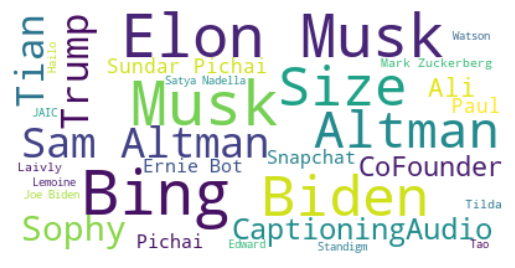

In [30]:
# plot a word cloud

word_counts = spacy_peo_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
# filter only the entities labelled as location and count the number of occurences
spacy_loc_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'GPE'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_loc_top30

,Entities,Labels,count
1850,US,GPE,526
1841,U.S.,GPE,401
1337,PRNewswire,GPE,398
776,India,GPE,372
356,China,GPE,367
1845,UK,GPE,217
826,Japan,GPE,173
320,Canada,GPE,141
605,France,GPE,125
2270,the United States,GPE,125


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

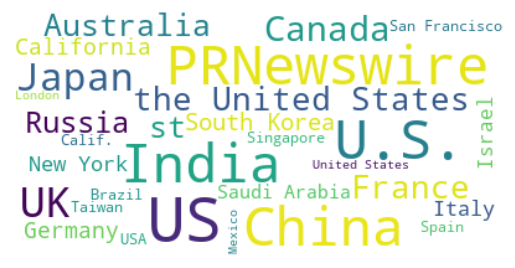

In [32]:
# plot a word cloud

word_counts = spacy_loc_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()